In [1]:
import scomv
import stlearn as st
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2
import pandas as pd
import numpy as np
import anndata
import scanpy as sc
import seaborn as sns
from adjustText import adjust_text
from scipy.cluster.hierarchy import linkage, dendrogram, ClusterNode, to_tree

/Users/nomura/miniconda3/envs/sc-test310/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
/Users/nomura/miniconda3/envs/sc-test310/lib/python3.10/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/nomura/miniconda3/envs/sc-test310/lib/python3.10/site-packages/stlearn/tl/cci/het.py:206: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/referenc

In [2]:
cd /Users/nomura/SpatialCompassV/docs/tutorials/

/Users/nomura/SpatialCompassV/docs/tutorials


/Users/nomura/miniconda3/envs/sc-test310/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
#!mkdir tutorial_data
#!mkdir tutorial_data/xenium_data
#!wget -P tutorial_data/xenium_data/ https://cf.10xgenomics.com/samples/xenium/preview/Xenium_FFPE_Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_cell_feature_matrix.h5
#!wget -P tutorial_data/xenium_data/ https://cf.10xgenomics.com/samples/xenium/preview/Xenium_FFPE_Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv.gz

In [4]:
# Load Xenium data using stlearn
adata = st.ReadXenium(
    feature_cell_matrix_file="tutorial_data/xenium_data/Xenium_FFPE_Human_Breast_Cancer_Rep1_cell_feature_matrix.h5",
    cell_summary_file="tutorial_data/xenium_data/Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv.gz",
    library_id="example data",
    image_path=None,
    scale=1,
    spot_diameter_fullres=10
)

In [5]:
# Gridding at 10μm interval using stlearn
N_COL = int((adata.obs.imagecol.max() - adata.obs.imagecol.min()) / 10)
N_ROW = int((adata.obs.imagerow.max() - adata.obs.imagerow.min()) / 10)
grid = st.tl.cci.grid(adata, n_row=N_ROW, n_col=N_COL, n_cpus=10, verbose=False)

In [6]:
from scomv.preparation.skny_calc_distance import calculate_distance

In [7]:
## apply SKNY
grid = calculate_distance(
    grid, pos_marker_ls=['CDH1',"EPCAM"],
)

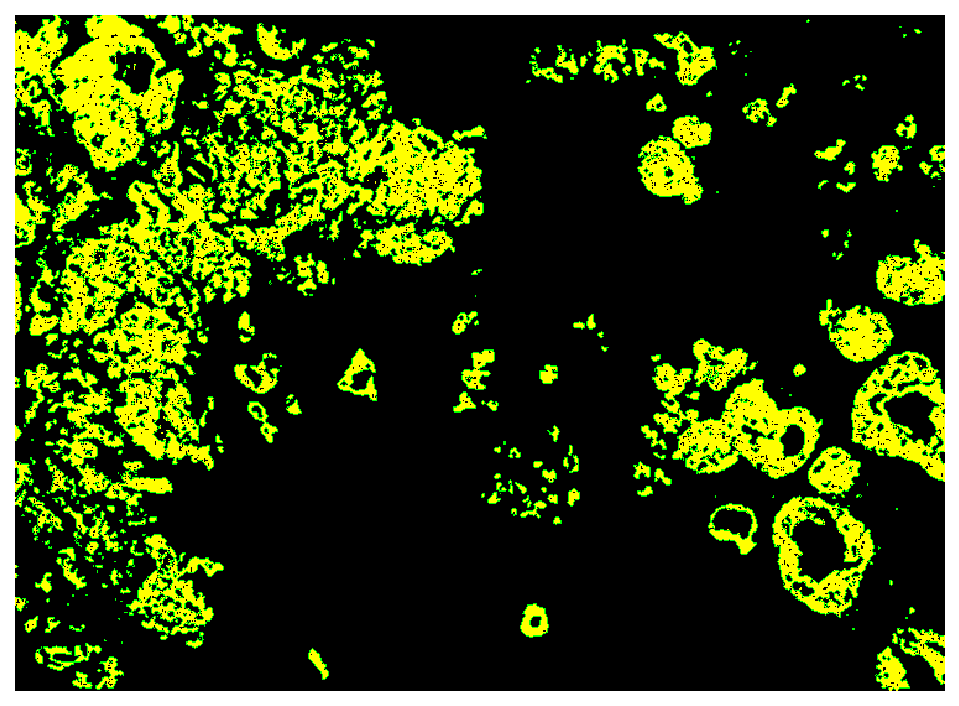

In [8]:
# Figure 2B
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
ax.imshow(cv2.cvtColor(grid.uns["marker_median_delineation"], cv2.COLOR_BGR2RGB),
          interpolation="nearest")
ax.axis("off")
plt.show()

#plt.savefig("Figure_2B.png", dpi=300)

In [9]:
# annotation each section to obs object
df_shotest = getattr(grid, "shortest")
df_grid = grid.to_df()

# extract grid info
df_grid = pd.merge(
    pd.DataFrame(index=["grid_" + str(i+1) for i in range(N_ROW * N_COL)]),
    df_grid, right_index=True, left_index=True, how="left"
).fillna(np.nan)

# extract section info
df_region = pd.DataFrame(
    np.array(df_shotest["region"]).reshape(N_ROW, N_COL).T.reshape(N_ROW * N_COL),
    index=["grid_" + str(i+1) for i in range(N_ROW * N_COL)], columns=["region"]
)

# marge
df_grid_region = pd.merge(
    df_grid, df_region,
    right_index=True, left_index=True, how="left"
)
df_grid_region = df_grid_region.dropna()

# add to obs
grid.obs = pd.merge(
    grid.obs, df_grid_region[["region"]],
    right_index=True, left_index=True, how="left"
)

# shaping
grid.obs["region_10"] = [str(i*10) for i in grid.obs["region"]]
grid.obs["region_10"] = ["("+str(int(float(i.split(", ")[0][1:])))+", "+str(int(float(i.split(", ")[-1][:-1])))+"]" if i != "nan" else np.nan for i in grid.obs["region_10"]]
# exclude because of small number
grid.obs["region_10"] = grid.obs["region_10"].replace(
    {"(-150, -120]": np.nan}
)

In [10]:
from scomv.preparation.choose_roi import extract_roi, contour_regions

In [11]:
# select ROI
roi = (2400, 3400, 2400, 3800)

subset_grid, filtered_shortest, xy_list = extract_roi(
    grid=grid,
    roi=roi,
    bin_size=10,
    region_col="region_10",
)


In [12]:
g_x_cont, g_y_cont, g_x_inside, g_y_inside = contour_regions(
    filtered_shortest, adata,
    min_x=0, max_x=4000, min_y=0, max_y=4000,
    out_dir_base="./roi_plots",
    show=False,
)

In [13]:
from scomv.preparation.scomv_calc_vector import compute_min_vectors_polar

In [14]:
outline_points = list(zip(g_x_cont, g_y_cont))
inside_points  = list(zip(g_x_inside, g_y_inside))

min_vector_df = compute_min_vectors_polar(
    xy_list=xy_list,
    outline_points=outline_points,
    inside_points=inside_points,
    invert_y=True,
    make_inside_negative=True,
)

In [15]:
from scomv.gene_view_tool import plot_gene_polar_hist2d, plot_2d_expression

CD3E: n=3426


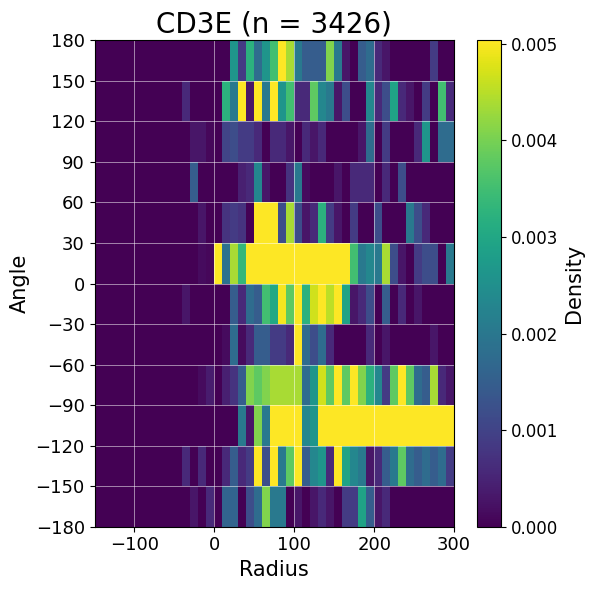

In [16]:
## Draw polar maps
genes = list(subset_grid.var.index)
A_counts, total_n, idx = plot_gene_polar_hist2d(
    subset_grid=subset_grid,
    min_vector_df=min_vector_df,
    gene="CD3E",
)


Please specify a valid `library_id` or set it permanently in `adata.uns['spatial']`


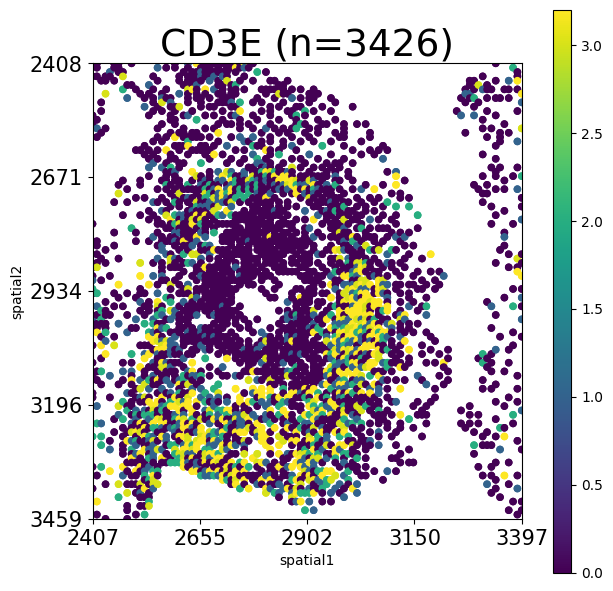

In [17]:
## Draw 2D pictures
g = ["CD3E"] # the genes you want to draw
for g in ["CD3E"]:
    plot_2d_expression(g, subset_grid)

In [18]:
from scomv.gene_pipeline import SCOMVPipeline

gene_pipe = SCOMVPipeline(adata=adata, grid=grid, bin_size=10)
gene_out = gene_pipe.run(roi=(2400, 3400, 2400, 3800))

/Users/nomura/miniconda3/envs/sc-test310/lib/python3.10/site-packages/scanpy/metrics/_morans_i.py:105: UserWarning: 1 variables were constant, will return nan for these.
  return _MoransI(graph, vals)()


  0%|          | 0/100 [00:00<?, ?/s]

/Users/nomura/miniconda3/envs/sc-test310/lib/python3.10/site-packages/scanpy/metrics/_morans_i.py:105: UserWarning: 1 variables were constant, will return nan for these.
  return _MoransI(graph, vals)()
/Users/nomura/miniconda3/envs/sc-test310/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
/Users/nomura/miniconda3/envs/sc-test310/lib/python3.10/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


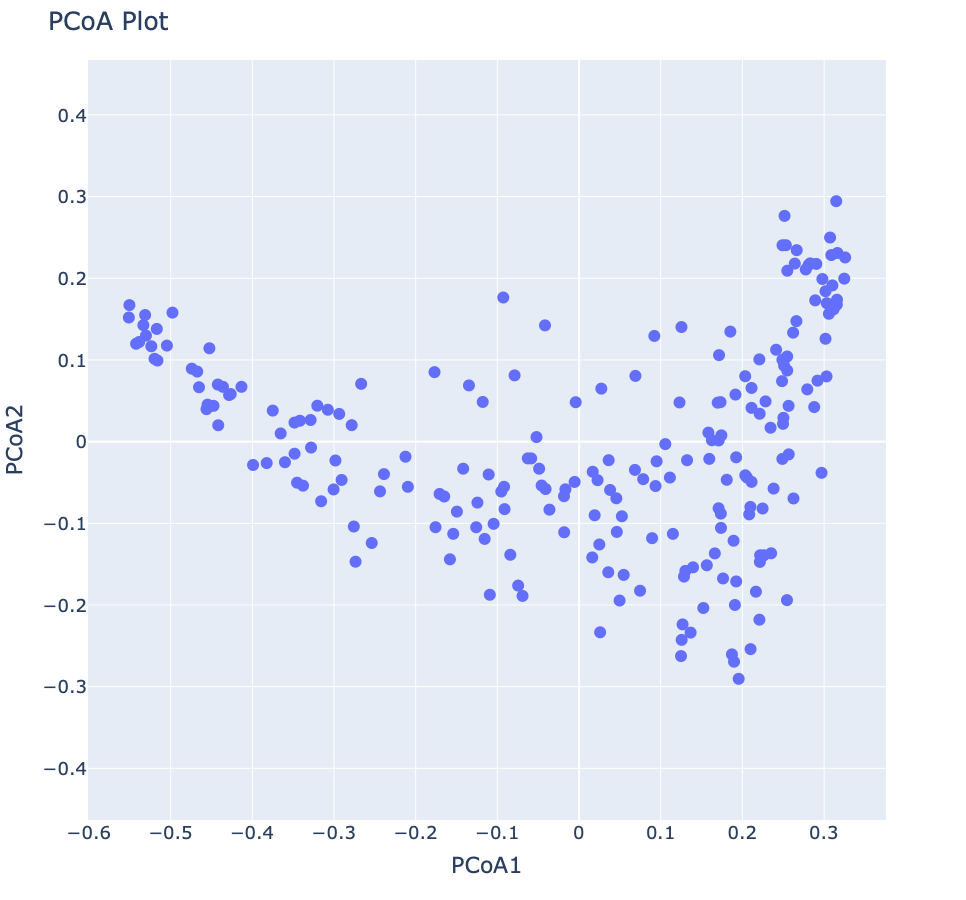

In [19]:
gene_pipe.plot_pcoa_plotly(gene_pipe.coords, gene_pipe.selected_genes)

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


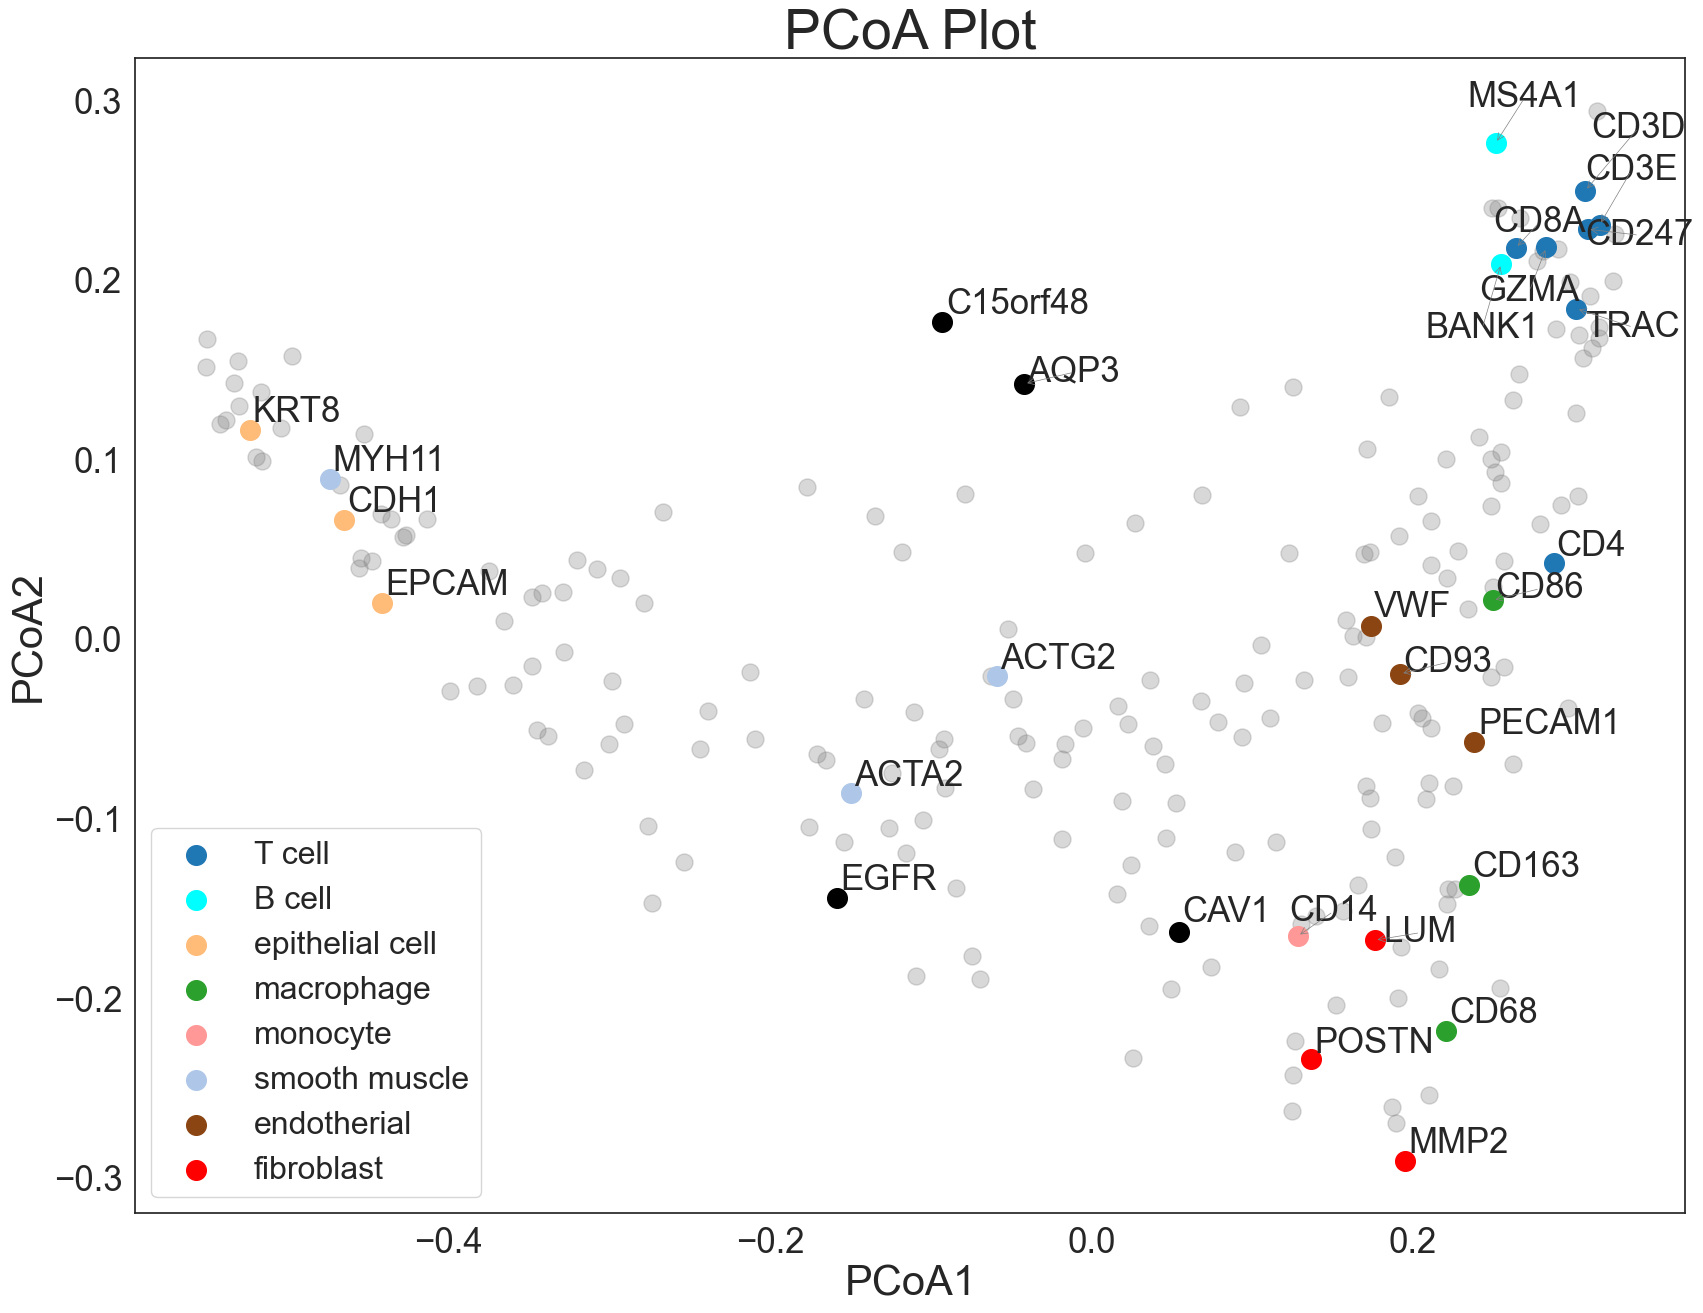

In [20]:
pcoa_two_dims = gene_out["coords"][["PC1", "PC2"]]
df = pcoa_two_dims

# --- Gene sets ---
t_cells  = {"CD3D", "CD3E", "CD4", "CD247", "CD8A", "GZMA", "TRAC"}
micro_f  = ["CD68", "CD80", "CD86", "CD163"]
b_cells  = ["CD19", "BANK1", "MS4A1", "TCL1A", "CD79A"]
mono     = ["CD14"]
epi      = ["CDH1", "EPCAM", "KRT8"]
smooth   = ["ACTA2", "MYH11", "ACTG2"]
endo     = ["CD93", "PECAM1", "VWF"]
fib      = ["POSTN", "LUM", "MMP2"]
focus    = ["PLVAP", "RHOA", "SMAD6", "TP53", "VEGFA", "MKI67", "ADGRL4", "RGS5",
            "PI3", "CAV1", "EGFR", "AQP3", "C15orf48"]

# --- Others (everything except T-cell set) ---
others = sorted(list(set(df.index) - set(t_cells)))

# --- Styling config (keeps your colors/labels/sizes) ---
groups = [
    ("T cell",          t_cells,  "#1f77b4", 200, True),
    ("B cell",          b_cells,  "cyan",    200, True),
    ("epithelial cell", epi,      "#ffbb78", 200, True),
    ("macrophage",      micro_f,  "#2ca02c", 200, True),
    ("monocyte",        mono,     "#ff9896", 200, True),
    ("smooth muscle",   smooth,   "#aec7e8", 200, True),
    ("endotherial",     endo,     "#8B4513", 200, True), 
    ("fibroblast",      fib,      "red",     200, True),
    (None,              focus,    "black",   200, True),  # no legend label
]

# --- Plot ---
plt.figure(figsize=(20, 15))
sns.set_theme(style="white")
texts = []

# Others: gray points (no labels)
for g in others:
    if g in df.index:
        plt.scatter(df.loc[g, "PC1"], df.loc[g, "PC2"], color="gray", alpha=0.3, s=150)

# Highlighted groups
for label, gene_list, color, s, add_text in groups:
    for g in gene_list:
        if g in df.index:
            if label is None:
                plt.scatter(df.loc[g, "PC1"], df.loc[g, "PC2"], color=color, s=s)
            else:
                plt.scatter(df.loc[g, "PC1"], df.loc[g, "PC2"], color=color, label=label, s=s)
            if add_text:
                texts.append(plt.text(df.loc[g, "PC1"], df.loc[g, "PC2"], g, fontsize=25))

plt.xlabel("PCoA1", fontsize=30)
plt.ylabel("PCoA2", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title("PCoA Plot", fontsize=40)

# Legend (remove duplicates)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="best", prop={"size": 23}, ncol=1)

adjust_text(
    texts,
    arrowprops=dict(arrowstyle="->", color="gray", lw=0.5),
    only_move={"points": "xy", "text": "xy"},
    force_text=1.5,
    force_points=1.0,
    expand_text=(1.2, 1.2),
    expand_points=(1.2, 1.2),
    lim=200,
    precision=0.01,
    autoalign="y",
)

plt.show()

In [22]:
from scomv.plot_3d import plot_3d

fig = plot_3d(
     adata=gene_out["subset_grid"],
     genes=("POSTN", "CD3E"),
     anchor_gene="CDH1",
     bin_size=10,
     x_range=(2400, 3100),
     y_range=(2400, 3400),
     height_scale=5,
     anchor_scale=1,
     threshold=4,
     sigma=1.0,
 )

In [28]:
from scomv.dendrogram import dendrogram2newick
z = linkage(gene_out["dist_df"], metric='euclidean', method='ward')
tree= to_tree(z)
newick = dendrogram2newick(tree, tree.dist, gene_out["selected_genes"])

/var/folders/h5/02yhm93d3kn1__fczqjdr9cw0000gp/T/ipykernel_66411/1097620655.py:2: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



In [30]:
#newick